# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [43]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

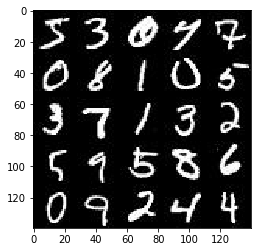

In [44]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

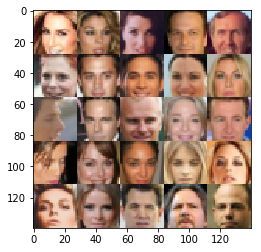

In [45]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [47]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):

    real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "real_input")
    z = tf.placeholder(tf.float32, [None, z_dim], "z_input")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "c:\\users\\lukas\\anaconda3\\envs\\tv-scripts\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "c:\\users\\lukas\\anaconda3\\envs\\tv-scripts\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "c:\\users\\lukas\\anaconda3\\envs\\tv-scripts\\lib\\site-packages\\ipykernel\\__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "c:\\users\\lukas\\anaconda3\\envs\\tv-scripts\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "c:\\users\\lukas\\anaconda3\\envs\\tv-scripts\\lib\\site-packages\\ipykernel\\kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [48]:
def discriminator(images, reuse=False):
   
    alpha = 0.01
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        layer1 = tf.layers.conv2d(images, 64, 5, 2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        layer1 = tf.maximum(alpha*layer1, layer1)
        layer1 = tf.nn.dropout(layer1, keep_prob=0.4)
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, 2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha*layer2, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.4)
    
        layer3 = tf.layers.conv2d(layer2, 256, 5, 2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha*layer3, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.4)
        
        flat   = tf.reshape(layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        output = tf.sigmoid(logits)
        
    return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [54]:
def generator(z, out_channel_dim, is_train=True):
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        layer1 = tf.layers.dense(z, 2*2*512)
        layer1 = tf.reshape(layer1, (-1, 2, 2, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha*layer1, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, 2 , padding='valid', activation=None)
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha*layer2, layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, 2 , padding='same', activation=None)
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha*layer3, layer3)
        
        layer3 = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, 2 , padding='same', activation=None)
        out = tf.tanh(layer3)

    return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [55]:
def model_loss(input_real, input_z, out_channel_dim):
   
    generator_model = generator(input_z, out_channel_dim)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)))
    
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    return discriminator_loss, generator_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [56]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        trainable_variables = tf.trainable_variables()
        
        discriminator_variables = [var for var in trainable_variables if var.name.startswith('discriminator')]
        generator_variables = [var for var in trainable_variables if var.name.startswith('generator')]

        discriminator_training_operation = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_variables)
        generator_training_operation = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_variables)

        return discriminator_training_operation, generator_training_operation


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [58]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    width, height, channel = data_shape[1], data_shape[2], data_shape[3]
    real_input, z_input, learn_rate = model_inputs(width, height, channel, z_dim)                                   
    discriminator_loss, generator_loss = model_loss(real_input, z_input, channel)
    discriminator_training_operation, generator_training_operation = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    step = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                sess.run(discriminator_training_operation, feed_dict={real_input: batch_images, z_input: batch_z, learn_rate: learning_rate})
                sess.run(generator_training_operation, feed_dict={real_input: batch_images, z_input: batch_z, learn_rate: learning_rate})
                
                # Prints every 10
                if step % 10 == 0:
                    train_loss_d = discriminator_loss.eval({real_input: batch_images, z_input: batch_z})
                    train_loss_g = generator_loss.eval({z_input: batch_z})
                    
                    print("Epoch {}/{}, Step {}".format(epoch_i+1, epoch_count, step),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                #Shows every 100 like the question reccomends.
                if step % 100 == 0:
                    show_generator_output(sess, 15, z_input, channel, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, Step 10 Discriminator Loss: 1.7466... Generator Loss: 1.0805
Epoch 1/2, Step 20 Discriminator Loss: 0.1994... Generator Loss: 4.3314
Epoch 1/2, Step 30 Discriminator Loss: 6.9632... Generator Loss: 9.4879
Epoch 1/2, Step 40 Discriminator Loss: 0.2436... Generator Loss: 3.8215
Epoch 1/2, Step 50 Discriminator Loss: 0.6489... Generator Loss: 3.3742
Epoch 1/2, Step 60 Discriminator Loss: 0.5158... Generator Loss: 2.2552
Epoch 1/2, Step 70 Discriminator Loss: 0.8496... Generator Loss: 2.3486
Epoch 1/2, Step 80 Discriminator Loss: 0.4814... Generator Loss: 2.6754
Epoch 1/2, Step 90 Discriminator Loss: 0.7842... Generator Loss: 1.2565
Epoch 1/2, Step 100 Discriminator Loss: 0.2606... Generator Loss: 3.2505


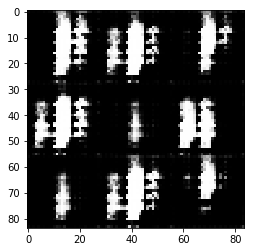

Epoch 1/2, Step 110 Discriminator Loss: 0.5018... Generator Loss: 4.1442
Epoch 1/2, Step 120 Discriminator Loss: 1.2503... Generator Loss: 5.5092
Epoch 1/2, Step 130 Discriminator Loss: 0.3881... Generator Loss: 7.4992
Epoch 1/2, Step 140 Discriminator Loss: 0.5501... Generator Loss: 2.0087
Epoch 1/2, Step 150 Discriminator Loss: 0.2154... Generator Loss: 3.9359
Epoch 1/2, Step 160 Discriminator Loss: 1.2394... Generator Loss: 0.7846
Epoch 1/2, Step 170 Discriminator Loss: 0.5201... Generator Loss: 4.4316
Epoch 1/2, Step 180 Discriminator Loss: 0.2826... Generator Loss: 3.3594
Epoch 1/2, Step 190 Discriminator Loss: 1.7064... Generator Loss: 0.6742
Epoch 1/2, Step 200 Discriminator Loss: 0.6907... Generator Loss: 3.0121


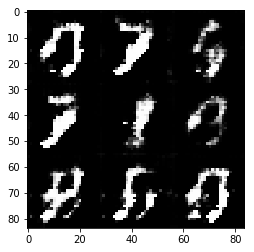

Epoch 1/2, Step 210 Discriminator Loss: 0.5344... Generator Loss: 1.8940
Epoch 1/2, Step 220 Discriminator Loss: 0.2671... Generator Loss: 2.8222
Epoch 1/2, Step 230 Discriminator Loss: 0.5494... Generator Loss: 2.0821
Epoch 1/2, Step 240 Discriminator Loss: 0.3958... Generator Loss: 2.6422
Epoch 1/2, Step 250 Discriminator Loss: 2.3133... Generator Loss: 6.6503
Epoch 1/2, Step 260 Discriminator Loss: 0.4790... Generator Loss: 1.8828
Epoch 1/2, Step 270 Discriminator Loss: 0.7785... Generator Loss: 2.4355
Epoch 1/2, Step 280 Discriminator Loss: 0.5541... Generator Loss: 2.6400
Epoch 1/2, Step 290 Discriminator Loss: 0.4355... Generator Loss: 2.7645
Epoch 1/2, Step 300 Discriminator Loss: 0.8256... Generator Loss: 1.5479


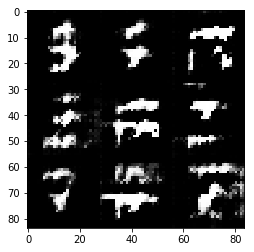

Epoch 1/2, Step 310 Discriminator Loss: 0.7113... Generator Loss: 1.5740
Epoch 1/2, Step 320 Discriminator Loss: 0.6427... Generator Loss: 2.0772
Epoch 1/2, Step 330 Discriminator Loss: 1.0091... Generator Loss: 4.1200
Epoch 1/2, Step 340 Discriminator Loss: 0.6530... Generator Loss: 2.2172
Epoch 1/2, Step 350 Discriminator Loss: 0.5447... Generator Loss: 2.9035
Epoch 1/2, Step 360 Discriminator Loss: 0.5034... Generator Loss: 2.5364
Epoch 1/2, Step 370 Discriminator Loss: 1.8283... Generator Loss: 6.5656
Epoch 1/2, Step 380 Discriminator Loss: 0.6362... Generator Loss: 1.9138
Epoch 1/2, Step 390 Discriminator Loss: 0.8292... Generator Loss: 1.5156
Epoch 1/2, Step 400 Discriminator Loss: 0.8306... Generator Loss: 1.5670


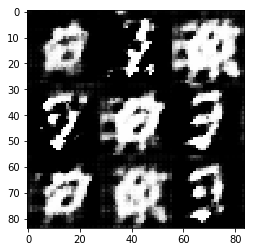

Epoch 1/2, Step 410 Discriminator Loss: 0.6675... Generator Loss: 2.3320
Epoch 1/2, Step 420 Discriminator Loss: 2.1250... Generator Loss: 0.3350
Epoch 1/2, Step 430 Discriminator Loss: 1.1859... Generator Loss: 4.0399
Epoch 1/2, Step 440 Discriminator Loss: 0.8738... Generator Loss: 1.1038
Epoch 1/2, Step 450 Discriminator Loss: 1.8488... Generator Loss: 3.9357
Epoch 1/2, Step 460 Discriminator Loss: 0.6253... Generator Loss: 1.7628
Epoch 2/2, Step 470 Discriminator Loss: 0.9578... Generator Loss: 1.4104
Epoch 2/2, Step 480 Discriminator Loss: 0.8457... Generator Loss: 2.3235
Epoch 2/2, Step 490 Discriminator Loss: 0.9708... Generator Loss: 1.7790
Epoch 2/2, Step 500 Discriminator Loss: 0.8896... Generator Loss: 1.7891


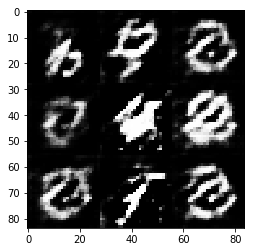

Epoch 2/2, Step 510 Discriminator Loss: 0.5142... Generator Loss: 1.9774
Epoch 2/2, Step 520 Discriminator Loss: 1.4388... Generator Loss: 0.7057
Epoch 2/2, Step 530 Discriminator Loss: 0.9055... Generator Loss: 1.9521
Epoch 2/2, Step 540 Discriminator Loss: 0.8856... Generator Loss: 1.3780
Epoch 2/2, Step 550 Discriminator Loss: 1.1636... Generator Loss: 2.5084
Epoch 2/2, Step 560 Discriminator Loss: 0.7979... Generator Loss: 1.9500
Epoch 2/2, Step 570 Discriminator Loss: 0.7471... Generator Loss: 2.2939
Epoch 2/2, Step 580 Discriminator Loss: 1.1009... Generator Loss: 1.3698
Epoch 2/2, Step 590 Discriminator Loss: 0.9672... Generator Loss: 1.2222
Epoch 2/2, Step 600 Discriminator Loss: 0.8322... Generator Loss: 2.0098


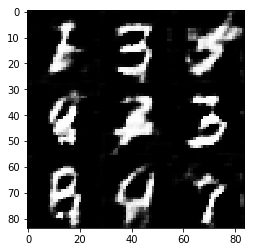

Epoch 2/2, Step 610 Discriminator Loss: 0.8557... Generator Loss: 1.4534
Epoch 2/2, Step 620 Discriminator Loss: 0.8345... Generator Loss: 1.9892
Epoch 2/2, Step 630 Discriminator Loss: 1.2409... Generator Loss: 2.3163
Epoch 2/2, Step 640 Discriminator Loss: 0.7187... Generator Loss: 1.4945
Epoch 2/2, Step 650 Discriminator Loss: 0.8801... Generator Loss: 1.4296
Epoch 2/2, Step 660 Discriminator Loss: 0.9173... Generator Loss: 2.3682
Epoch 2/2, Step 670 Discriminator Loss: 0.8864... Generator Loss: 1.5846
Epoch 2/2, Step 680 Discriminator Loss: 0.8422... Generator Loss: 1.4455
Epoch 2/2, Step 690 Discriminator Loss: 0.8684... Generator Loss: 1.4052
Epoch 2/2, Step 700 Discriminator Loss: 1.1316... Generator Loss: 1.2703


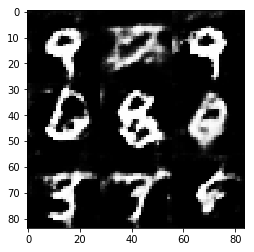

Epoch 2/2, Step 710 Discriminator Loss: 0.9405... Generator Loss: 1.2816
Epoch 2/2, Step 720 Discriminator Loss: 0.8164... Generator Loss: 1.4541
Epoch 2/2, Step 730 Discriminator Loss: 1.0360... Generator Loss: 1.5575
Epoch 2/2, Step 740 Discriminator Loss: 0.8614... Generator Loss: 1.1905
Epoch 2/2, Step 750 Discriminator Loss: 1.2201... Generator Loss: 2.3720
Epoch 2/2, Step 760 Discriminator Loss: 0.9273... Generator Loss: 1.1876
Epoch 2/2, Step 770 Discriminator Loss: 1.1243... Generator Loss: 2.1592
Epoch 2/2, Step 780 Discriminator Loss: 0.9107... Generator Loss: 1.1874
Epoch 2/2, Step 790 Discriminator Loss: 0.9770... Generator Loss: 1.1371
Epoch 2/2, Step 800 Discriminator Loss: 1.3054... Generator Loss: 2.2349


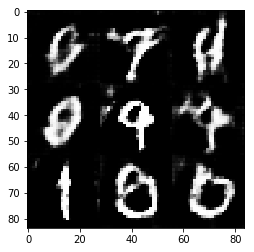

Epoch 2/2, Step 810 Discriminator Loss: 0.9257... Generator Loss: 1.3707
Epoch 2/2, Step 820 Discriminator Loss: 1.0064... Generator Loss: 1.4490
Epoch 2/2, Step 830 Discriminator Loss: 0.9112... Generator Loss: 2.1746
Epoch 2/2, Step 840 Discriminator Loss: 0.8846... Generator Loss: 1.2251
Epoch 2/2, Step 850 Discriminator Loss: 1.3707... Generator Loss: 0.7748
Epoch 2/2, Step 860 Discriminator Loss: 1.1072... Generator Loss: 0.8658
Epoch 2/2, Step 870 Discriminator Loss: 0.9087... Generator Loss: 1.4870
Epoch 2/2, Step 880 Discriminator Loss: 0.9761... Generator Loss: 1.4848
Epoch 2/2, Step 890 Discriminator Loss: 0.9991... Generator Loss: 1.6660
Epoch 2/2, Step 900 Discriminator Loss: 1.0102... Generator Loss: 1.4236


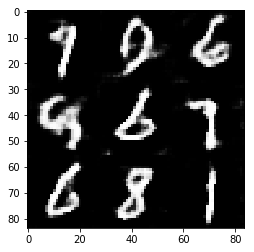

Epoch 2/2, Step 910 Discriminator Loss: 1.3507... Generator Loss: 0.6372
Epoch 2/2, Step 920 Discriminator Loss: 1.1782... Generator Loss: 1.0288
Epoch 2/2, Step 930 Discriminator Loss: 1.0438... Generator Loss: 1.5181


In [59]:
batch_size = 128
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, Step 10 Discriminator Loss: 2.8817... Generator Loss: 0.2134
Epoch 1/1, Step 20 Discriminator Loss: 1.7508... Generator Loss: 0.7697
Epoch 1/1, Step 30 Discriminator Loss: 1.0778... Generator Loss: 1.5897
Epoch 1/1, Step 40 Discriminator Loss: 0.6717... Generator Loss: 2.5807
Epoch 1/1, Step 50 Discriminator Loss: 0.1629... Generator Loss: 3.8652
Epoch 1/1, Step 60 Discriminator Loss: 0.3341... Generator Loss: 2.3440
Epoch 1/1, Step 70 Discriminator Loss: 0.7032... Generator Loss: 3.6314
Epoch 1/1, Step 80 Discriminator Loss: 0.3113... Generator Loss: 3.3514
Epoch 1/1, Step 90 Discriminator Loss: 0.2651... Generator Loss: 3.1132
Epoch 1/1, Step 100 Discriminator Loss: 0.6425... Generator Loss: 1.4565


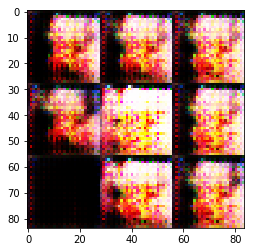

Epoch 1/1, Step 110 Discriminator Loss: 0.4143... Generator Loss: 2.1182
Epoch 1/1, Step 120 Discriminator Loss: 1.5456... Generator Loss: 0.6176
Epoch 1/1, Step 130 Discriminator Loss: 0.6196... Generator Loss: 3.2618
Epoch 1/1, Step 140 Discriminator Loss: 0.9887... Generator Loss: 1.2977
Epoch 1/1, Step 150 Discriminator Loss: 0.3090... Generator Loss: 2.9562
Epoch 1/1, Step 160 Discriminator Loss: 1.2769... Generator Loss: 2.4555
Epoch 1/1, Step 170 Discriminator Loss: 0.7330... Generator Loss: 2.0408
Epoch 1/1, Step 180 Discriminator Loss: 1.2979... Generator Loss: 0.9214
Epoch 1/1, Step 190 Discriminator Loss: 0.4222... Generator Loss: 3.0992
Epoch 1/1, Step 200 Discriminator Loss: 1.2187... Generator Loss: 4.1742


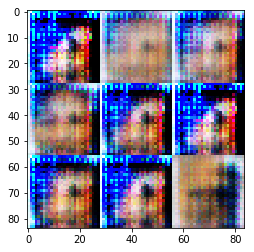

Epoch 1/1, Step 210 Discriminator Loss: 0.8274... Generator Loss: 1.0001
Epoch 1/1, Step 220 Discriminator Loss: 3.0916... Generator Loss: 6.2998
Epoch 1/1, Step 230 Discriminator Loss: 1.9718... Generator Loss: 0.4382
Epoch 1/1, Step 240 Discriminator Loss: 0.5941... Generator Loss: 2.3649
Epoch 1/1, Step 250 Discriminator Loss: 1.1784... Generator Loss: 1.1287
Epoch 1/1, Step 260 Discriminator Loss: 0.8544... Generator Loss: 1.4326
Epoch 1/1, Step 270 Discriminator Loss: 1.8128... Generator Loss: 2.0938
Epoch 1/1, Step 280 Discriminator Loss: 1.5090... Generator Loss: 0.4519
Epoch 1/1, Step 290 Discriminator Loss: 0.8062... Generator Loss: 2.3560
Epoch 1/1, Step 300 Discriminator Loss: 0.5278... Generator Loss: 1.6166


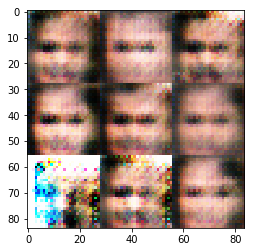

Epoch 1/1, Step 310 Discriminator Loss: 1.3954... Generator Loss: 0.8016
Epoch 1/1, Step 320 Discriminator Loss: 1.0793... Generator Loss: 0.8592
Epoch 1/1, Step 330 Discriminator Loss: 1.0503... Generator Loss: 1.1881
Epoch 1/1, Step 340 Discriminator Loss: 1.1555... Generator Loss: 0.6285
Epoch 1/1, Step 350 Discriminator Loss: 1.2079... Generator Loss: 0.8082
Epoch 1/1, Step 360 Discriminator Loss: 0.4841... Generator Loss: 1.7915
Epoch 1/1, Step 370 Discriminator Loss: 2.5041... Generator Loss: 4.0291
Epoch 1/1, Step 380 Discriminator Loss: 1.4846... Generator Loss: 0.6964
Epoch 1/1, Step 390 Discriminator Loss: 1.1111... Generator Loss: 1.2113
Epoch 1/1, Step 400 Discriminator Loss: 1.3023... Generator Loss: 0.8124


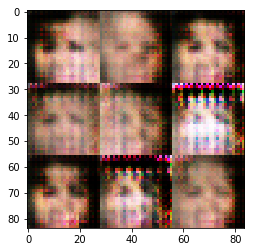

Epoch 1/1, Step 410 Discriminator Loss: 1.3477... Generator Loss: 1.3536
Epoch 1/1, Step 420 Discriminator Loss: 1.1741... Generator Loss: 1.4117
Epoch 1/1, Step 430 Discriminator Loss: 1.0522... Generator Loss: 1.1164
Epoch 1/1, Step 440 Discriminator Loss: 1.6583... Generator Loss: 1.3298
Epoch 1/1, Step 450 Discriminator Loss: 1.4238... Generator Loss: 2.2353
Epoch 1/1, Step 460 Discriminator Loss: 1.0626... Generator Loss: 0.9775
Epoch 1/1, Step 470 Discriminator Loss: 1.5695... Generator Loss: 0.5672
Epoch 1/1, Step 480 Discriminator Loss: 1.4469... Generator Loss: 2.2476
Epoch 1/1, Step 490 Discriminator Loss: 0.9566... Generator Loss: 0.7781
Epoch 1/1, Step 500 Discriminator Loss: 1.5170... Generator Loss: 0.4906


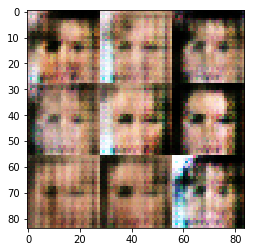

Epoch 1/1, Step 510 Discriminator Loss: 1.5260... Generator Loss: 1.9587
Epoch 1/1, Step 520 Discriminator Loss: 1.4460... Generator Loss: 1.0300
Epoch 1/1, Step 530 Discriminator Loss: 1.2118... Generator Loss: 0.7071
Epoch 1/1, Step 540 Discriminator Loss: 1.0992... Generator Loss: 0.6929
Epoch 1/1, Step 550 Discriminator Loss: 0.4790... Generator Loss: 1.1886
Epoch 1/1, Step 560 Discriminator Loss: 1.7193... Generator Loss: 1.7771
Epoch 1/1, Step 570 Discriminator Loss: 0.7614... Generator Loss: 0.9205
Epoch 1/1, Step 580 Discriminator Loss: 1.1612... Generator Loss: 1.2486
Epoch 1/1, Step 590 Discriminator Loss: 1.4105... Generator Loss: 1.2023
Epoch 1/1, Step 600 Discriminator Loss: 1.2784... Generator Loss: 1.5061


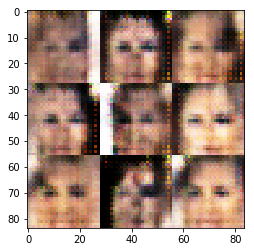

Epoch 1/1, Step 610 Discriminator Loss: 1.2402... Generator Loss: 0.8763
Epoch 1/1, Step 620 Discriminator Loss: 0.7742... Generator Loss: 1.4069
Epoch 1/1, Step 630 Discriminator Loss: 1.3693... Generator Loss: 0.7690
Epoch 1/1, Step 640 Discriminator Loss: 1.1897... Generator Loss: 0.8473
Epoch 1/1, Step 650 Discriminator Loss: 1.0133... Generator Loss: 1.0322
Epoch 1/1, Step 660 Discriminator Loss: 1.0048... Generator Loss: 1.0050
Epoch 1/1, Step 670 Discriminator Loss: 0.8344... Generator Loss: 1.1637
Epoch 1/1, Step 680 Discriminator Loss: 1.4158... Generator Loss: 1.7230
Epoch 1/1, Step 690 Discriminator Loss: 1.1384... Generator Loss: 0.6395
Epoch 1/1, Step 700 Discriminator Loss: 1.2771... Generator Loss: 1.5149


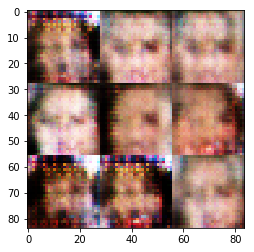

Epoch 1/1, Step 710 Discriminator Loss: 1.4276... Generator Loss: 1.0162
Epoch 1/1, Step 720 Discriminator Loss: 0.8999... Generator Loss: 1.3402
Epoch 1/1, Step 730 Discriminator Loss: 1.0495... Generator Loss: 0.9723
Epoch 1/1, Step 740 Discriminator Loss: 1.1152... Generator Loss: 0.8461
Epoch 1/1, Step 750 Discriminator Loss: 1.4986... Generator Loss: 1.1850
Epoch 1/1, Step 760 Discriminator Loss: 0.8683... Generator Loss: 1.3327
Epoch 1/1, Step 770 Discriminator Loss: 1.1362... Generator Loss: 1.3292
Epoch 1/1, Step 780 Discriminator Loss: 0.9844... Generator Loss: 0.9467
Epoch 1/1, Step 790 Discriminator Loss: 1.0612... Generator Loss: 0.9592
Epoch 1/1, Step 800 Discriminator Loss: 1.0262... Generator Loss: 0.7447


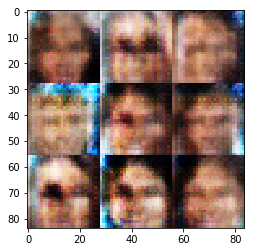

Epoch 1/1, Step 810 Discriminator Loss: 1.1763... Generator Loss: 1.3996
Epoch 1/1, Step 820 Discriminator Loss: 1.2685... Generator Loss: 0.6645
Epoch 1/1, Step 830 Discriminator Loss: 1.1894... Generator Loss: 0.9275
Epoch 1/1, Step 840 Discriminator Loss: 1.3758... Generator Loss: 1.5437
Epoch 1/1, Step 850 Discriminator Loss: 1.0479... Generator Loss: 1.0304
Epoch 1/1, Step 860 Discriminator Loss: 1.0387... Generator Loss: 1.0614
Epoch 1/1, Step 870 Discriminator Loss: 1.1896... Generator Loss: 0.8786
Epoch 1/1, Step 880 Discriminator Loss: 0.7684... Generator Loss: 0.8514
Epoch 1/1, Step 890 Discriminator Loss: 1.1603... Generator Loss: 1.3139
Epoch 1/1, Step 900 Discriminator Loss: 0.9526... Generator Loss: 0.7935


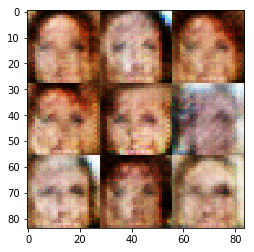

Epoch 1/1, Step 910 Discriminator Loss: 0.9499... Generator Loss: 0.7509
Epoch 1/1, Step 920 Discriminator Loss: 0.9691... Generator Loss: 1.0179
Epoch 1/1, Step 930 Discriminator Loss: 1.3447... Generator Loss: 0.7368
Epoch 1/1, Step 940 Discriminator Loss: 1.0573... Generator Loss: 0.7602
Epoch 1/1, Step 950 Discriminator Loss: 1.1340... Generator Loss: 0.9865
Epoch 1/1, Step 960 Discriminator Loss: 1.1581... Generator Loss: 0.8410
Epoch 1/1, Step 970 Discriminator Loss: 1.1441... Generator Loss: 1.0178
Epoch 1/1, Step 980 Discriminator Loss: 1.1015... Generator Loss: 1.0578
Epoch 1/1, Step 990 Discriminator Loss: 1.4370... Generator Loss: 1.4703
Epoch 1/1, Step 1000 Discriminator Loss: 1.3343... Generator Loss: 0.9609


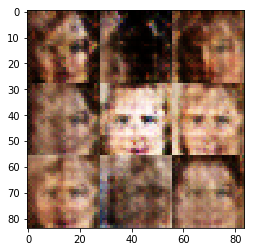

Epoch 1/1, Step 1010 Discriminator Loss: 1.2236... Generator Loss: 0.9300
Epoch 1/1, Step 1020 Discriminator Loss: 1.2939... Generator Loss: 1.2219
Epoch 1/1, Step 1030 Discriminator Loss: 1.1595... Generator Loss: 0.8593
Epoch 1/1, Step 1040 Discriminator Loss: 1.4527... Generator Loss: 0.5942
Epoch 1/1, Step 1050 Discriminator Loss: 1.3267... Generator Loss: 1.0484
Epoch 1/1, Step 1060 Discriminator Loss: 1.1325... Generator Loss: 0.8723
Epoch 1/1, Step 1070 Discriminator Loss: 1.3552... Generator Loss: 1.1026
Epoch 1/1, Step 1080 Discriminator Loss: 1.1664... Generator Loss: 1.0441
Epoch 1/1, Step 1090 Discriminator Loss: 0.7615... Generator Loss: 0.9056
Epoch 1/1, Step 1100 Discriminator Loss: 1.2861... Generator Loss: 1.2257


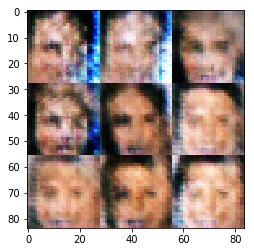

Epoch 1/1, Step 1110 Discriminator Loss: 0.9460... Generator Loss: 1.0767
Epoch 1/1, Step 1120 Discriminator Loss: 1.1482... Generator Loss: 0.9090
Epoch 1/1, Step 1130 Discriminator Loss: 1.4371... Generator Loss: 1.2597
Epoch 1/1, Step 1140 Discriminator Loss: 1.0318... Generator Loss: 1.1929
Epoch 1/1, Step 1150 Discriminator Loss: 1.2190... Generator Loss: 0.7703
Epoch 1/1, Step 1160 Discriminator Loss: 1.2552... Generator Loss: 1.0618
Epoch 1/1, Step 1170 Discriminator Loss: 1.5278... Generator Loss: 0.7211
Epoch 1/1, Step 1180 Discriminator Loss: 1.0615... Generator Loss: 1.0066
Epoch 1/1, Step 1190 Discriminator Loss: 0.9067... Generator Loss: 1.2350
Epoch 1/1, Step 1200 Discriminator Loss: 1.2748... Generator Loss: 1.0513


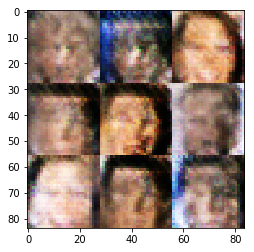

Epoch 1/1, Step 1210 Discriminator Loss: 1.0324... Generator Loss: 0.9042
Epoch 1/1, Step 1220 Discriminator Loss: 1.1854... Generator Loss: 0.8974
Epoch 1/1, Step 1230 Discriminator Loss: 1.1605... Generator Loss: 0.9227
Epoch 1/1, Step 1240 Discriminator Loss: 0.6452... Generator Loss: 1.0243
Epoch 1/1, Step 1250 Discriminator Loss: 0.9735... Generator Loss: 0.7499
Epoch 1/1, Step 1260 Discriminator Loss: 1.2172... Generator Loss: 0.9386
Epoch 1/1, Step 1270 Discriminator Loss: 1.4767... Generator Loss: 2.2556
Epoch 1/1, Step 1280 Discriminator Loss: 0.9050... Generator Loss: 0.7955
Epoch 1/1, Step 1290 Discriminator Loss: 1.4552... Generator Loss: 0.8671
Epoch 1/1, Step 1300 Discriminator Loss: 0.9684... Generator Loss: 0.9291


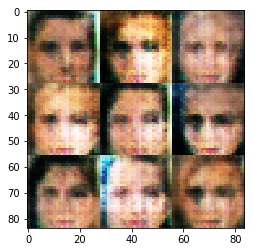

Epoch 1/1, Step 1310 Discriminator Loss: 0.9768... Generator Loss: 0.8285
Epoch 1/1, Step 1320 Discriminator Loss: 1.1099... Generator Loss: 1.0038
Epoch 1/1, Step 1330 Discriminator Loss: 1.0274... Generator Loss: 0.6617
Epoch 1/1, Step 1340 Discriminator Loss: 1.2785... Generator Loss: 1.1065
Epoch 1/1, Step 1350 Discriminator Loss: 1.0919... Generator Loss: 0.8676
Epoch 1/1, Step 1360 Discriminator Loss: 1.1485... Generator Loss: 0.7004
Epoch 1/1, Step 1370 Discriminator Loss: 0.9814... Generator Loss: 0.7982
Epoch 1/1, Step 1380 Discriminator Loss: 1.2176... Generator Loss: 0.9196
Epoch 1/1, Step 1390 Discriminator Loss: 0.9299... Generator Loss: 0.7937
Epoch 1/1, Step 1400 Discriminator Loss: 1.5273... Generator Loss: 1.4701


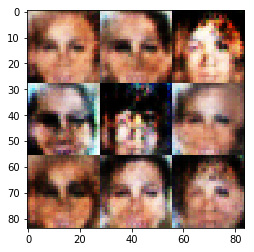

Epoch 1/1, Step 1410 Discriminator Loss: 1.1847... Generator Loss: 0.7605
Epoch 1/1, Step 1420 Discriminator Loss: 1.4320... Generator Loss: 0.8671
Epoch 1/1, Step 1430 Discriminator Loss: 1.0398... Generator Loss: 1.3842
Epoch 1/1, Step 1440 Discriminator Loss: 1.0606... Generator Loss: 0.7068
Epoch 1/1, Step 1450 Discriminator Loss: 1.3716... Generator Loss: 1.0358
Epoch 1/1, Step 1460 Discriminator Loss: 1.2139... Generator Loss: 0.6585
Epoch 1/1, Step 1470 Discriminator Loss: 1.1544... Generator Loss: 0.7977
Epoch 1/1, Step 1480 Discriminator Loss: 1.3258... Generator Loss: 1.2091
Epoch 1/1, Step 1490 Discriminator Loss: 1.5062... Generator Loss: 1.1285
Epoch 1/1, Step 1500 Discriminator Loss: 0.6571... Generator Loss: 1.0036


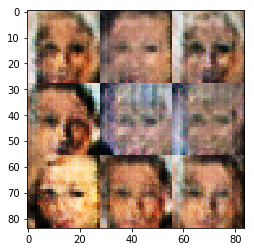

Epoch 1/1, Step 1510 Discriminator Loss: 1.2955... Generator Loss: 1.2566
Epoch 1/1, Step 1520 Discriminator Loss: 1.3468... Generator Loss: 0.9454
Epoch 1/1, Step 1530 Discriminator Loss: 1.4918... Generator Loss: 0.9943
Epoch 1/1, Step 1540 Discriminator Loss: 1.1780... Generator Loss: 1.1566
Epoch 1/1, Step 1550 Discriminator Loss: 1.1948... Generator Loss: 1.0047
Epoch 1/1, Step 1560 Discriminator Loss: 0.8902... Generator Loss: 0.7668
Epoch 1/1, Step 1570 Discriminator Loss: 1.3467... Generator Loss: 1.1412
Epoch 1/1, Step 1580 Discriminator Loss: 1.1962... Generator Loss: 0.9374
Epoch 1/1, Step 1590 Discriminator Loss: 1.3644... Generator Loss: 1.0332
Epoch 1/1, Step 1600 Discriminator Loss: 1.0199... Generator Loss: 0.7268


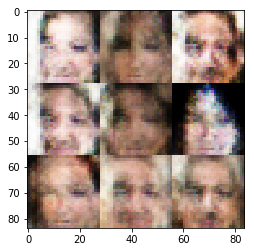

Epoch 1/1, Step 1610 Discriminator Loss: 1.3729... Generator Loss: 1.0220
Epoch 1/1, Step 1620 Discriminator Loss: 1.1700... Generator Loss: 0.9738
Epoch 1/1, Step 1630 Discriminator Loss: 1.3668... Generator Loss: 1.2774
Epoch 1/1, Step 1640 Discriminator Loss: 1.1569... Generator Loss: 0.7041
Epoch 1/1, Step 1650 Discriminator Loss: 1.2830... Generator Loss: 0.9580
Epoch 1/1, Step 1660 Discriminator Loss: 1.2752... Generator Loss: 1.0677
Epoch 1/1, Step 1670 Discriminator Loss: 1.3315... Generator Loss: 0.7336
Epoch 1/1, Step 1680 Discriminator Loss: 1.1290... Generator Loss: 0.7090
Epoch 1/1, Step 1690 Discriminator Loss: 1.2401... Generator Loss: 0.8528
Epoch 1/1, Step 1700 Discriminator Loss: 1.4498... Generator Loss: 0.9829


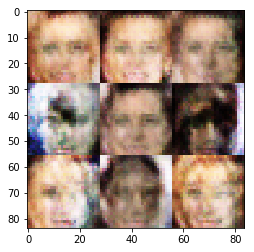

Epoch 1/1, Step 1710 Discriminator Loss: 1.2134... Generator Loss: 0.9025
Epoch 1/1, Step 1720 Discriminator Loss: 1.1212... Generator Loss: 0.9574
Epoch 1/1, Step 1730 Discriminator Loss: 1.4044... Generator Loss: 0.8593
Epoch 1/1, Step 1740 Discriminator Loss: 1.0731... Generator Loss: 1.1303
Epoch 1/1, Step 1750 Discriminator Loss: 1.1069... Generator Loss: 0.6611
Epoch 1/1, Step 1760 Discriminator Loss: 1.2779... Generator Loss: 0.5914
Epoch 1/1, Step 1770 Discriminator Loss: 1.1884... Generator Loss: 0.9660
Epoch 1/1, Step 1780 Discriminator Loss: 1.0376... Generator Loss: 0.9046
Epoch 1/1, Step 1790 Discriminator Loss: 1.3711... Generator Loss: 0.6598
Epoch 1/1, Step 1800 Discriminator Loss: 1.2969... Generator Loss: 1.1110


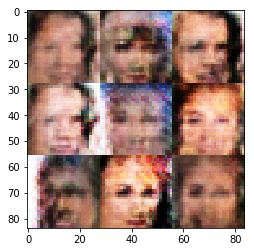

Epoch 1/1, Step 1810 Discriminator Loss: 1.2843... Generator Loss: 0.7312
Epoch 1/1, Step 1820 Discriminator Loss: 1.2612... Generator Loss: 0.8574
Epoch 1/1, Step 1830 Discriminator Loss: 1.1875... Generator Loss: 0.7664
Epoch 1/1, Step 1840 Discriminator Loss: 1.2700... Generator Loss: 0.8763
Epoch 1/1, Step 1850 Discriminator Loss: 1.2179... Generator Loss: 0.6943
Epoch 1/1, Step 1860 Discriminator Loss: 1.2197... Generator Loss: 0.9149
Epoch 1/1, Step 1870 Discriminator Loss: 1.0734... Generator Loss: 0.8097
Epoch 1/1, Step 1880 Discriminator Loss: 1.0394... Generator Loss: 0.7571
Epoch 1/1, Step 1890 Discriminator Loss: 1.3183... Generator Loss: 0.9663
Epoch 1/1, Step 1900 Discriminator Loss: 1.2150... Generator Loss: 0.8885


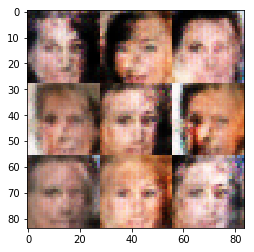

Epoch 1/1, Step 1910 Discriminator Loss: 1.2534... Generator Loss: 0.9537
Epoch 1/1, Step 1920 Discriminator Loss: 1.2132... Generator Loss: 0.7449
Epoch 1/1, Step 1930 Discriminator Loss: 1.5740... Generator Loss: 0.9903
Epoch 1/1, Step 1940 Discriminator Loss: 1.3482... Generator Loss: 0.5819
Epoch 1/1, Step 1950 Discriminator Loss: 0.9873... Generator Loss: 0.9998
Epoch 1/1, Step 1960 Discriminator Loss: 1.0701... Generator Loss: 0.7881
Epoch 1/1, Step 1970 Discriminator Loss: 1.2829... Generator Loss: 1.0060
Epoch 1/1, Step 1980 Discriminator Loss: 1.2667... Generator Loss: 1.1151
Epoch 1/1, Step 1990 Discriminator Loss: 1.3363... Generator Loss: 0.8438
Epoch 1/1, Step 2000 Discriminator Loss: 1.2236... Generator Loss: 0.6909


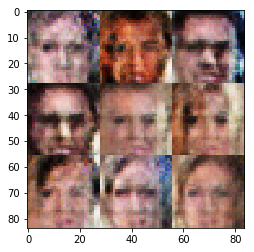

Epoch 1/1, Step 2010 Discriminator Loss: 1.2994... Generator Loss: 0.9715
Epoch 1/1, Step 2020 Discriminator Loss: 1.2620... Generator Loss: 0.9172
Epoch 1/1, Step 2030 Discriminator Loss: 1.3013... Generator Loss: 0.8558
Epoch 1/1, Step 2040 Discriminator Loss: 0.9026... Generator Loss: 0.7945
Epoch 1/1, Step 2050 Discriminator Loss: 1.4176... Generator Loss: 1.4398
Epoch 1/1, Step 2060 Discriminator Loss: 1.1614... Generator Loss: 0.7651
Epoch 1/1, Step 2070 Discriminator Loss: 1.1169... Generator Loss: 0.9511
Epoch 1/1, Step 2080 Discriminator Loss: 1.4169... Generator Loss: 0.8829
Epoch 1/1, Step 2090 Discriminator Loss: 1.2803... Generator Loss: 0.5966
Epoch 1/1, Step 2100 Discriminator Loss: 1.2204... Generator Loss: 0.9479


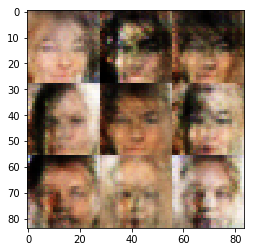

Epoch 1/1, Step 2110 Discriminator Loss: 0.7871... Generator Loss: 0.9626
Epoch 1/1, Step 2120 Discriminator Loss: 1.4490... Generator Loss: 0.7061
Epoch 1/1, Step 2130 Discriminator Loss: 1.1950... Generator Loss: 0.8138
Epoch 1/1, Step 2140 Discriminator Loss: 1.0866... Generator Loss: 0.7774
Epoch 1/1, Step 2150 Discriminator Loss: 1.3366... Generator Loss: 0.8734
Epoch 1/1, Step 2160 Discriminator Loss: 1.0002... Generator Loss: 0.9362
Epoch 1/1, Step 2170 Discriminator Loss: 1.4321... Generator Loss: 0.7923
Epoch 1/1, Step 2180 Discriminator Loss: 0.8561... Generator Loss: 0.7110
Epoch 1/1, Step 2190 Discriminator Loss: 1.4147... Generator Loss: 1.0312
Epoch 1/1, Step 2200 Discriminator Loss: 1.2816... Generator Loss: 0.9029


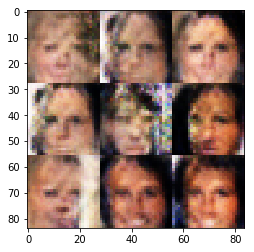

Epoch 1/1, Step 2210 Discriminator Loss: 1.0502... Generator Loss: 0.8604
Epoch 1/1, Step 2220 Discriminator Loss: 1.4879... Generator Loss: 0.9644
Epoch 1/1, Step 2230 Discriminator Loss: 1.1926... Generator Loss: 0.5146
Epoch 1/1, Step 2240 Discriminator Loss: 1.2402... Generator Loss: 0.7749
Epoch 1/1, Step 2250 Discriminator Loss: 1.3568... Generator Loss: 0.9084
Epoch 1/1, Step 2260 Discriminator Loss: 1.4037... Generator Loss: 0.9454
Epoch 1/1, Step 2270 Discriminator Loss: 1.1622... Generator Loss: 0.7092
Epoch 1/1, Step 2280 Discriminator Loss: 1.4283... Generator Loss: 0.7057
Epoch 1/1, Step 2290 Discriminator Loss: 1.2865... Generator Loss: 0.8461
Epoch 1/1, Step 2300 Discriminator Loss: 1.3185... Generator Loss: 0.9181


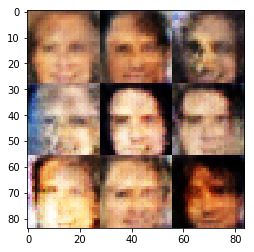

Epoch 1/1, Step 2310 Discriminator Loss: 1.2212... Generator Loss: 0.7111
Epoch 1/1, Step 2320 Discriminator Loss: 1.2933... Generator Loss: 0.7165
Epoch 1/1, Step 2330 Discriminator Loss: 1.2433... Generator Loss: 0.7447
Epoch 1/1, Step 2340 Discriminator Loss: 1.3434... Generator Loss: 0.9662
Epoch 1/1, Step 2350 Discriminator Loss: 1.4429... Generator Loss: 0.8946
Epoch 1/1, Step 2360 Discriminator Loss: 1.5334... Generator Loss: 0.6269
Epoch 1/1, Step 2370 Discriminator Loss: 1.2868... Generator Loss: 0.9055
Epoch 1/1, Step 2380 Discriminator Loss: 0.9783... Generator Loss: 0.7337
Epoch 1/1, Step 2390 Discriminator Loss: 1.4473... Generator Loss: 1.0320
Epoch 1/1, Step 2400 Discriminator Loss: 1.3418... Generator Loss: 0.8655


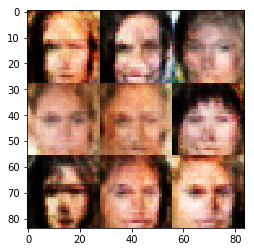

Epoch 1/1, Step 2410 Discriminator Loss: 1.2548... Generator Loss: 0.9219
Epoch 1/1, Step 2420 Discriminator Loss: 1.1361... Generator Loss: 0.8716
Epoch 1/1, Step 2430 Discriminator Loss: 1.2891... Generator Loss: 0.8288
Epoch 1/1, Step 2440 Discriminator Loss: 1.4061... Generator Loss: 0.7454
Epoch 1/1, Step 2450 Discriminator Loss: 1.3012... Generator Loss: 0.9090
Epoch 1/1, Step 2460 Discriminator Loss: 1.3445... Generator Loss: 1.1309
Epoch 1/1, Step 2470 Discriminator Loss: 1.2297... Generator Loss: 0.7317
Epoch 1/1, Step 2480 Discriminator Loss: 1.4110... Generator Loss: 1.1139
Epoch 1/1, Step 2490 Discriminator Loss: 1.3462... Generator Loss: 0.9962
Epoch 1/1, Step 2500 Discriminator Loss: 0.9871... Generator Loss: 0.9151


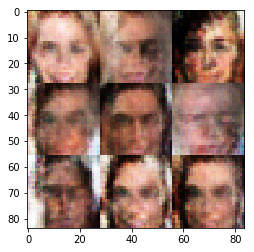

Epoch 1/1, Step 2510 Discriminator Loss: 1.2831... Generator Loss: 0.9106
Epoch 1/1, Step 2520 Discriminator Loss: 1.5148... Generator Loss: 0.6954
Epoch 1/1, Step 2530 Discriminator Loss: 1.3118... Generator Loss: 0.9722
Epoch 1/1, Step 2540 Discriminator Loss: 1.1845... Generator Loss: 0.7377
Epoch 1/1, Step 2550 Discriminator Loss: 1.2163... Generator Loss: 0.5926
Epoch 1/1, Step 2560 Discriminator Loss: 1.2669... Generator Loss: 0.8193
Epoch 1/1, Step 2570 Discriminator Loss: 1.3285... Generator Loss: 1.1096
Epoch 1/1, Step 2580 Discriminator Loss: 1.2124... Generator Loss: 0.7054
Epoch 1/1, Step 2590 Discriminator Loss: 0.8770... Generator Loss: 0.6730
Epoch 1/1, Step 2600 Discriminator Loss: 1.2664... Generator Loss: 1.1874


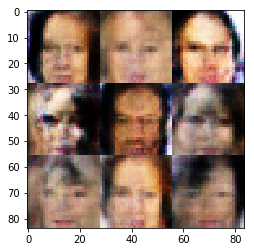

Epoch 1/1, Step 2610 Discriminator Loss: 1.0580... Generator Loss: 0.6747
Epoch 1/1, Step 2620 Discriminator Loss: 1.2802... Generator Loss: 0.8648
Epoch 1/1, Step 2630 Discriminator Loss: 1.2270... Generator Loss: 0.8237
Epoch 1/1, Step 2640 Discriminator Loss: 1.2459... Generator Loss: 0.7831
Epoch 1/1, Step 2650 Discriminator Loss: 1.2419... Generator Loss: 0.9606
Epoch 1/1, Step 2660 Discriminator Loss: 1.2854... Generator Loss: 1.2050
Epoch 1/1, Step 2670 Discriminator Loss: 1.2368... Generator Loss: 0.7351
Epoch 1/1, Step 2680 Discriminator Loss: 1.2842... Generator Loss: 0.8931
Epoch 1/1, Step 2690 Discriminator Loss: 1.1206... Generator Loss: 0.8164
Epoch 1/1, Step 2700 Discriminator Loss: 1.6798... Generator Loss: 0.8639


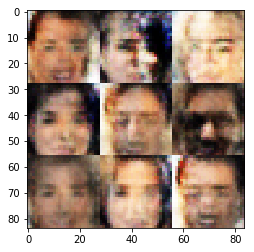

Epoch 1/1, Step 2710 Discriminator Loss: 1.0878... Generator Loss: 0.9104
Epoch 1/1, Step 2720 Discriminator Loss: 1.4991... Generator Loss: 0.4784
Epoch 1/1, Step 2730 Discriminator Loss: 1.3246... Generator Loss: 0.6849
Epoch 1/1, Step 2740 Discriminator Loss: 1.2787... Generator Loss: 1.1562
Epoch 1/1, Step 2750 Discriminator Loss: 1.0370... Generator Loss: 0.8626
Epoch 1/1, Step 2760 Discriminator Loss: 1.3769... Generator Loss: 0.7279
Epoch 1/1, Step 2770 Discriminator Loss: 1.0803... Generator Loss: 0.8583
Epoch 1/1, Step 2780 Discriminator Loss: 1.3630... Generator Loss: 0.6769
Epoch 1/1, Step 2790 Discriminator Loss: 1.2059... Generator Loss: 0.8425
Epoch 1/1, Step 2800 Discriminator Loss: 1.2966... Generator Loss: 0.9656


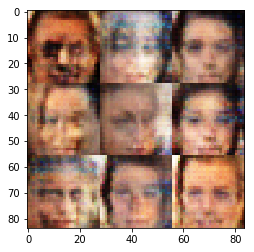

Epoch 1/1, Step 2810 Discriminator Loss: 1.2160... Generator Loss: 0.9497
Epoch 1/1, Step 2820 Discriminator Loss: 1.2163... Generator Loss: 0.9132
Epoch 1/1, Step 2830 Discriminator Loss: 1.3268... Generator Loss: 0.9895
Epoch 1/1, Step 2840 Discriminator Loss: 1.1929... Generator Loss: 0.9375
Epoch 1/1, Step 2850 Discriminator Loss: 1.3151... Generator Loss: 1.0153
Epoch 1/1, Step 2860 Discriminator Loss: 1.2020... Generator Loss: 0.7354
Epoch 1/1, Step 2870 Discriminator Loss: 1.5027... Generator Loss: 0.8755
Epoch 1/1, Step 2880 Discriminator Loss: 1.3552... Generator Loss: 0.4247
Epoch 1/1, Step 2890 Discriminator Loss: 1.4865... Generator Loss: 0.7625
Epoch 1/1, Step 2900 Discriminator Loss: 1.4680... Generator Loss: 0.8112


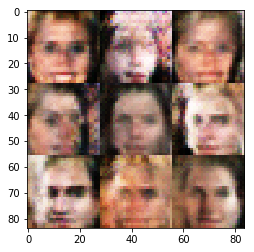

Epoch 1/1, Step 2910 Discriminator Loss: 1.3189... Generator Loss: 0.7897
Epoch 1/1, Step 2920 Discriminator Loss: 1.2329... Generator Loss: 0.7507
Epoch 1/1, Step 2930 Discriminator Loss: 1.2715... Generator Loss: 0.8060
Epoch 1/1, Step 2940 Discriminator Loss: 1.2527... Generator Loss: 0.7977
Epoch 1/1, Step 2950 Discriminator Loss: 1.3091... Generator Loss: 0.8834
Epoch 1/1, Step 2960 Discriminator Loss: 1.1825... Generator Loss: 0.6719
Epoch 1/1, Step 2970 Discriminator Loss: 1.3498... Generator Loss: 0.8424
Epoch 1/1, Step 2980 Discriminator Loss: 1.0625... Generator Loss: 0.8339
Epoch 1/1, Step 2990 Discriminator Loss: 1.3095... Generator Loss: 0.6571
Epoch 1/1, Step 3000 Discriminator Loss: 1.5764... Generator Loss: 0.6604


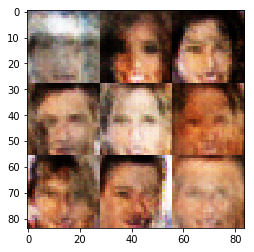

Epoch 1/1, Step 3010 Discriminator Loss: 1.4149... Generator Loss: 1.0602
Epoch 1/1, Step 3020 Discriminator Loss: 1.1637... Generator Loss: 0.8378
Epoch 1/1, Step 3030 Discriminator Loss: 1.3442... Generator Loss: 0.9851
Epoch 1/1, Step 3040 Discriminator Loss: 1.2835... Generator Loss: 1.0440
Epoch 1/1, Step 3050 Discriminator Loss: 1.2590... Generator Loss: 0.8028
Epoch 1/1, Step 3060 Discriminator Loss: 1.4343... Generator Loss: 1.0663
Epoch 1/1, Step 3070 Discriminator Loss: 1.5333... Generator Loss: 0.6109
Epoch 1/1, Step 3080 Discriminator Loss: 1.4408... Generator Loss: 0.9595
Epoch 1/1, Step 3090 Discriminator Loss: 1.3452... Generator Loss: 0.7088
Epoch 1/1, Step 3100 Discriminator Loss: 1.3076... Generator Loss: 0.8637


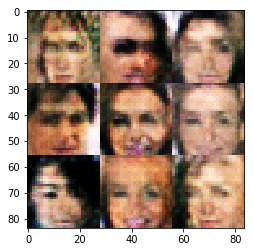

Epoch 1/1, Step 3110 Discriminator Loss: 1.3453... Generator Loss: 1.0060
Epoch 1/1, Step 3120 Discriminator Loss: 1.3689... Generator Loss: 0.8885
Epoch 1/1, Step 3130 Discriminator Loss: 1.4905... Generator Loss: 0.7478
Epoch 1/1, Step 3140 Discriminator Loss: 1.3497... Generator Loss: 0.8102
Epoch 1/1, Step 3150 Discriminator Loss: 0.9857... Generator Loss: 0.8002
Epoch 1/1, Step 3160 Discriminator Loss: 1.3088... Generator Loss: 0.7119


In [60]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.